<a href="https://colab.research.google.com/github/jpedro-rod/ElementosFinitos/blob/main/Elementos_Finitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elementos Finitos 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import itertools as it   #biblioteca com funções de permutação a serem usadas na interação da matriz de conectividade com a global

Formulação forte de um problema de condução de calor estacionário em uma placa:

$\nabla\cdot\vec{q} + G = 0 \;,\;\; \vec{q} = -k\nabla T$

Formulação fraca:

$∫_{\Omega}[\nabla\cdot\vec{q} + G]\cdot \omega(x,y) \;\; d\Omega = 0, ∀\omega \in U^0$

$∫_{\Omega}[\nabla\cdot\vec{q}\omega + G\omega] \;\; d\Omega = 0, ∀\omega \in U^0$

Pelo Teorema de Green (que assume a forma de integral por partes em 01 dimensão):

$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma - \int_{Ω} \nabla\omega\cdot\vec{q} \;\; dΩ + \int_{\Omega} G\omega \;\; dΩ= 0 \;\;\;\; (I)$

Reescrevendo a 1ª parcela em função das condições de contorno, ter-se-á:

$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma = \int_{\Gamma_q} \omega\vec{q}\cdot\vec{n} \; d\Gamma_q + \int_{\Gamma_T} \omega\vec{q}\cdot\vec{n} \; d\Gamma_T$

Sabe-se ainda que $\omega(x,y)=0$ em $\Gamma_T$ (para C.C. de Dirichlet), o que simplifica a equação oriunda do Teorema de Green:

$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma = \int_{\Gamma_q} \omega\vec{q}\cdot\vec{n} \; d\Gamma_q \;\;\;\; (II)$

Inserindo $II$ em $I$ e definindo $\overline{q}=\vec{q}\cdot\vec{n}$ finalmente:

$\int_{Ω} \nabla\omega\cdot\vec{q} \;\; dΩ = \int_{\Gamma_q} \omega\overline{q} \;\; dΓ_q + \int_{\Omega} \omega G \;\; dΩ$

$\int_{Ω} \nabla\omega\cdot(-k\nabla T) \;\; dΩ = \int_{\Gamma_q} \omega\overline{q} \;\; dΓ_q + \int_{\Omega} \omega G \;\; dΩ$

Discretizando a fórmula fraca:

$\int_{Ω} -B^{e^T}\omega^{e^T} \cdot k \cdot B^eT^e dΩ^e = \int_{\Gamma_q} N^{e^T}\omega^{e^T}\overline{q} \;\; dΓ_q^e + \int_{\Omega} N^{e^T}\omega^{e^T}G \;\; dΩ^e$

Onde $N^e$ é *matriz* de funções de interpolação (ou de forma) e $B^e$ é matriz das derivadas de $N^e$

$\int_{Ω} -B^{e^T} k B^e \cdot T^e dΩ^e = \int_{\Gamma_q} N^{e^T}\overline{q} \;\; dΓ_q^e + \int_{\Omega} N^{e^T}G \;\; dΩ^e$

## Funções de forma (ou de interpolação)

In [2]:
#1ª ordem:
#N1 = [N11, N12]

def N11(x,X1,X2):
    return (X2-x)/(X2-X1)

def N12(x,X1,X2):
    return (x-X1)/(X2-X1)

def B11(x,X1,X2):
    return -1/(X2-X1)

def B12(x,X1,X2):
    return 1/(X2-X1)

#2ª ordem:
#N2 = [N21, N22, N23]

def N21(x,X1,X2,X3):
    return 2*(x-X2)*(x-X3)/(X3-X1)**2

def N22(x,X1,X2,X3):
    return (-4)*(x-X1)*(x-X3)/(X3-X1)**2

def N23(x,X1,X2,X3):
    return 2*(x-X1)*(x-X2)/(X3-X1)**2

# B2 = [B21, B22, B23]

def B21(x,X1,X2,X3):
    return 2*(2*x-(X2+X3))/(X3-X1)**2

def B22(x,X1,X2,X3):
    return (-4)*(2*x-(X1+X3))/(X3-X1)**2

def B23(x,X1,X2,X3):
    return 2*(2*x-(X1+X2))/(X3-X1)**2

## Condução de calor em barra delgada

Condução de calor numa barra fina e homogênea com extremidades a temperaturas fixas e submetida a geração de calor de comportamento linear:

$L = 4\:m = 4 \;,\;\; A = 1\:m^2 \;,\;\; K = 5\:W/(°Cm)$

$G(x) = \frac{50}{3}(x+2) \;,\;\; T(x=1) = 100°C \;,\;\; T(x=4) = 0$

$$\int_{Ω} B^{e^T} k B^e \; dx^e \cdot T^e + \int_{\Omega} N^{e^T}G \;\; dx^e = 0$$

Matriz de conectividade: 
[[ 0.  1.]
 [ 1.  2.]
 [ 2.  3.]
 [ 3.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 7.  8.]
 [ 8.  9.]
 [ 9. 10.]
 [10. 11.]
 [11. 12.]
 [12. 13.]
 [13. 14.]
 [14. 15.]
 [15. 16.]
 [16. 17.]
 [17. 18.]
 [18. 19.]
 [19. 20.]
 [20. 21.]
 [21. 22.]
 [22. 23.]
 [23. 24.]]

Matrizes globais singulares: 
Ks
Gs

Matrizes globais: 
K
G

Campo de temperatura (solução numérica): 
[100.    93.41  86.99  80.73  74.65  68.76  63.05  57.53  52.22  47.12
  42.23  37.56  33.12  28.92  24.96  21.24  17.78  14.58  11.64   8.98
   6.6    4.5    2.7    1.2    0.  ]
[[1.     1.015  1.03   1.045  1.06   1.075  1.09   1.105  1.12  ]
 [1.12   1.1368 1.1536 1.1704 1.1872 1.204  1.2208 1.2376 1.2544]
 [1.24   1.2586 1.2772 1.2958 1.3144 1.333  1.3516 1.3702 1.3888]
 [1.36   1.3804 1.4008 1.4212 1.4416 1.462  1.4824 1.5028 1.5232]
 [1.48   1.5022 1.5244 1.5466 1.5688 1.591  1.6132 1.6354 1.6576]
 [1.6    1.624  1.648  1.672  1.696  1.72   1.744  1.768  1.792 ]
 [1.72   1.7458 1.7716 1.7974 

ValueError: x and y must have same first dimension, but have shapes (240,) and (216,)

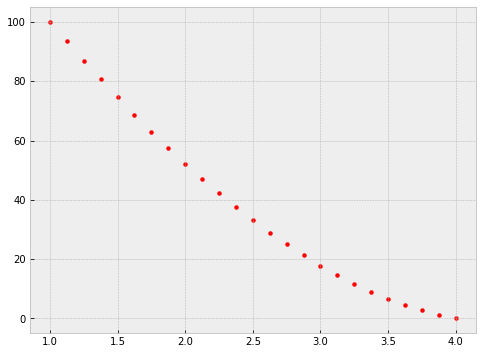

In [69]:
#Parâmetros Físicos

Xo = 1
Xf = 4
A = 1
k = 5
To = 100
Tf = 0

def S(x):
    return (50/3)*(x+2)

#Parâmetros numéricos############################

#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.

ordemElemento = 1   #1 ou 2

ligacoes = 25                              #PARA 2ª ORDEM SOMENTE NÚMEROS ÍMPARES
malha = np.linspace(Xo,Xf,ligacoes)

#################################################

##Produtos das funções de forma 1ª ordem
if ordemElemento == 1:

    ###Definindo nº de elementos e nós 
    nElementos = len(malha)-1          #O nº de elementos sempre será inteiro independente se nº de ligações é par ou impar
    nNos = nElementos+1
    
    nNosLocais = 2

    K11 = lambda x,X1,X2 : B11(x,X1,X2)*k*B11(x,X1,X2)
    K12 = lambda x,X1,X2 : B11(x,X1,X2)*k*B12(x,X1,X2)
    K21 = lambda x,X1,X2 : B12(x,X1,X2)*k*B11(x,X1,X2)
    K22 = lambda x,X1,X2 : B12(x,X1,X2)*k*B12(x,X1,X2)

    G1 = lambda x,X1,X2 : S(x)*N11(x,X1,X2)
    G2 = lambda x,X1,X2 : S(x)*N12(x,X1,X2)

    ###Função de integração a ser usada
    def INTEGRACAO_1(f,X1,X2):
        return sp.integrate.quad(f,X1,X2,(X1,X2))[0]

##Integrando e montando
    listaKe = np.empty((2,2,nElementos))
    listaGe = np.empty((1,2,nElementos))

    for e in range(0,nElementos):
        Ke = np.array([[INTEGRACAO_1(K11,malha[e],malha[e+1]),INTEGRACAO_1(K12,malha[e],malha[e+1])],
                    [INTEGRACAO_1(K21,malha[e],malha[e+1]),INTEGRACAO_1(K22,malha[e],malha[e+1])]])         

        Ge = np.array([[INTEGRACAO_1(G1,malha[e],malha[e+1]),INTEGRACAO_1(G2,malha[e],malha[e+1])]])

        listaKe[:,:,e] = Ke
        listaGe[:,:,e] = Ge


##Produtos das funções de forma 2ª ordem
elif ordemElemento == 2:
    
    ###Definindo nº de elementos e nós
    nElementos = (len(malha)-1)/2          #O nº de elementos será inteiro quando nº de ligações for ímpar e racional quando nº de ligações for par
    nNos = int(3*nElementos - (nElementos-1))

    nNosLocais = 3
    
    nElementos = int(nElementos)     #Para ser possível realizar os loops mais abaixo e montar a lista de matrizes de elementos

    K11 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K12 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K13 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K21 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K22 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K23 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K31 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K32 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K33 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B23(x,X1,X2,X3)

    G1 = lambda x,X1,X2,X3 : S(x)*N21(x,X1,X2,X3)
    G2 = lambda x,X1,X2,X3 : S(x)*N22(x,X1,X2,X3)
    G3 = lambda x,X1,X2,X3 : S(x)*N23(x,X1,X2,X3)

    ###Função de integração a ser usada
    def INTEGRACAO_2(f,X1,X2,X3):
        return sp.integrate.quad(f,X1,X3,(X1,X2,X3))[0]

##Integrando e montando
    listaKe = np.empty((3,3,nElementos))
    listaGe = np.empty((1,3,nElementos))

    '''Há um if dentro do loop porque elementos de 2ª ordem podem terminar incompletos dependendo de como discretizarmos o domínio. Dessa forma é 
    necessário definir uma integração particular para o último elemento em que o integramos só até a metade'''
    
    indice_elemento = 0
    for e in range(0,nNos-1,2):
        
        Ke = np.array([[INTEGRACAO_2(K11,malha[e],malha[e+1],malha[e+2]),INTEGRACAO_2(K12,malha[e],malha[e+1],malha[e+2]),INTEGRACAO_2(K13,malha[e],malha[e+1],malha[e+2])],
                    [INTEGRACAO_2(K21,malha[e],malha[e+1],malha[e+2]),INTEGRACAO_2(K22,malha[e],malha[e+1],malha[e+2]),INTEGRACAO_2(K23,malha[e],malha[e+1],malha[e+2])],
                    [INTEGRACAO_2(K31,malha[e],malha[e+1],malha[e+2]),INTEGRACAO_2(K32,malha[e],malha[e+1],malha[e+2]),INTEGRACAO_2(K33,malha[e],malha[e+1],malha[e+2])]])
            
        Ge = np.array([[INTEGRACAO_2(G1,malha[e],malha[e+1],malha[e+2]),INTEGRACAO_2(G2,malha[e],malha[e+1],malha[e+2]),INTEGRACAO_2(G3,malha[e],malha[e+1],malha[e+2])]])

        listaKe[:,:,indice_elemento] = Ke
        listaGe[:,:,indice_elemento] = Ge
        indice_elemento = indice_elemento + 1

# Matriz de conectividade (IEN)

IEN = np.zeros((nElementos,nNosLocais))

##1ª ORDEM
if ordemElemento == 1:
        
    for elemento in range(nElementos):
        for noLocal in range(nNosLocais):
                
            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

##2ª ORDEM
elif ordemElemento == 2:
    for elemento in range(nElementos):

        for noLocal in range(nNosLocais):

            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

print("Matriz de conectividade: ")
print(IEN)

#Matrizes globais

Ks = np.zeros((nNos,nNos))    #Ks pois se refere a matriz global ainda em seu estado singular
Gs= np.zeros(nNos)

nMatrizesElementares = len(listaKe[0,0,:])

##1ª ORDEM
if ordemElemento == 1:

    ###Adicionando cada matriz elementar à matriz global
    for K_elementar_index in range(nMatrizesElementares):

        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(2):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
        #print(Gaux)
        Gs = Gs + Gaux
        
    print("\nMatrizes globais singulares: ")
    print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
##2ª ORDEM
elif ordemElemento == 2:

    ###Adicionando cada matriz elementar Ke à matriz global K
    for K_elementar_index in range(nMatrizesElementares):
        
        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
        
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        if ligacoes%2 == 0 and G_elementar_index == ultimoGe:

            for i in range(2):
                Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

            Gs = Gs + Gaux
        
        else:
            for i in range(3):
                Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

            Gs = Gs + Gaux
    
    print("\nMatrizes globais singulares: ")
    print("Ks")  
    print(np.array_str(Ks, precision=2, suppress_small=True))
    print("Gs")
    print(np.array_str(Gs, precision=2, suppress_small=True))
    
#Aplicação das condições de contorno na matriz e vetor independente:   K.T + G = 0

##K
###1º contorno
K = np.delete(Ks,obj=0,axis=0)   #eliminando linha
K = np.delete(K,obj=0, axis=1)   #eliminando coluna
###2º contorno
K = np.delete(K,obj=-1, axis=0)    #eliminando linha
K = np.delete(K,obj=-1, axis=1)   #eliminando coluna

##G
G = Gs[1:-1]
KLinhaEliminada = np.delete(Ks,obj=0,axis=0)
KLinhaEliminada = np.delete(KLinhaEliminada,obj=-1,axis=0)

for i in range(len(G)):

    G[i] = G[i] + To*KLinhaEliminada[i,0] + Tf*KLinhaEliminada[i,-1]

print("\nMatrizes globais: ")
print("K")  
#print(np.array_str(K, precision=2, suppress_small=True))
print("G")
#print(np.array_str(G, precision=2, suppress_small=True))

#Solucionando o sistema

CampoTSemContorno = np.linalg.solve(K,-G)

BCo = np.array([To])
BCf = np.array([Tf])
CampoTemperatura = np.concatenate((BCo,CampoTSemContorno,BCf))

print("\nCampo de temperatura (solução numérica): ")
print(np.array_str(CampoTemperatura, precision=2, suppress_small=True))

def CampoTNumerico(x, T):

    nNos = len(T)
    nElem = nNos - 1
    DominioElemento = np.linspace(1,1 + (Xf - Xo)/nNos,int(len(x)/nNos))

    Dominio = np.empty((nNos, len(DominioElemento)))
    comprimento = (Xf - Xo)/nNos

    for e in range(nNos):
            D = (Xo + comprimento*e)*DominioElemento
            Dominio[e] = D

    print(Dominio)
    #O Fim e o início de cada elemento coincidem, o que causaria uma repetição de valores na hora de concatenar a solução de cada elemento.
    #Por isso, fiz o 1º elemento completo à parte e os demais fiz sem o primeiro valor do elemento, pois ele já se enontra no fim do elemento anterior

    #1º elemento

    #TnumInicial = np.empty(nElem)

    #TnumInicial = N11(intervalosPorElemento[0], IEN[0,0], IEN[0,1])*T[0] + N12(intervalosPorElemento[0], IEN[0,0], IEN[0,1])*T[1]

    Tnum = np.empty((nElem,len(DominioElemento)))

    for i,elemento in enumerate(IEN):
        Xe0 = elemento[0]
        Xef = elemento[1]

        Tn = N11(Dominio[i], Xe0, Xef)*T[i] + N12(Dominio[i], Xe0, Xef)*T[i+1]

        Tnum[i] = Tn

    Tnum = Tnum.flatten()

    return Tnum

#Solução analítica

DominioAnalitico = np.linspace(Xo,Xf,240)

def CampoTAnalitico(x):
    return (5/9)*x**3 + (10/3)*x**2 - (185/3)*x + 1420/9

#Exibindo as soluções

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex = True, figsize = (8,6))

ax1.scatter(malha, CampoTemperatura, s=15, color='red',)
#ax1.plot(malha, CampoTemperatura, color='red',)
ax1.plot(DominioAnalitico, CampoTNumerico(DominioAnalitico, CampoTemperatura), color='red', linewidth=1.5)
ax1.plot(DominioAnalitico, CampoTAnalitico(DominioAnalitico), color='black', linewidth=1.5)
ax1.set_title('Condução de calor em barra delgada')
ax1.set_xlabel('Comprimento (m)')
ax1.set_ylabel('Temperatura (ºC)')
ax1.legend(loc='best',facecolor ='w')



## Condução de calor em placa 

In [53]:
T = np.array([1,2,3,4,5,6])
x = np.linspace(1,4,25)
print(x)
nNos = len(T)
nElem = nNos - 1
intervalosPorElemento = np.linspace(1,1 + (Xf - Xo)/nElem,int(len(x)/nElem))
print(intervalosPorElemento)
#intervalosPorElemento = x.reshape((nElem,int(len(x)/nElem)))


[1.    1.125 1.25  1.375 1.5   1.625 1.75  1.875 2.    2.125 2.25  2.375
 2.5   2.625 2.75  2.875 3.    3.125 3.25  3.375 3.5   3.625 3.75  3.875
 4.   ]
[1.   1.15 1.3  1.45 1.6 ]


## Rascunho